In [1]:
# Importing the required libraries.
import glob
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from statsmodels.stats.weightstats import DescrStatsW

In [33]:
path = r'Data/Prat'
all_files = glob.glob(path + "/*.csv")

li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

prat = pd.concat(li, axis=0, ignore_index=True)

In [34]:
def datawrangling(df):

    ## Calculates the min hourly wage of each individual and some wrangling

    ## Reanme columns
    df = df.rename(columns={'s_seker': 'year',"min":"gender"})

    ## Calculates the min hourly wage of each individual
    ## Codebook --> sh_shavua -> weekly work hours, shavuot -> monthly work weeks, i111prat -> monthly income from work, i112prat -> monthly income from self imployment
    df = df.loc[(df["i111prat"] > 0) & (df["i112prat"] == 0)]
    df["wage_hr"]= df['i111prat'] / (df['sh_shavua'] * df['shavuot'])
    
     ## Filter only individuals aged 30+
    df = df.loc[(df["age_group"]>5)]
    df = df.loc[(df["age_group"]<11)]

    df["quarter_year"]= df["quarter"].astype(str) + "-" + df["year"].astype(str)
    df["quarter_year"] = df.apply(lambda x: x["quarter_year"] if x["year"] < 2019 else 2019, axis=1)

    ## Merge Data on mandatory min wage for each year (For year in which the min wage was updated, keeped only the later)
    by_year = pd.read_excel("min_by_year_quart.xlsx")
    df = pd.merge(df, by_year, on="quarter_year", how="left")

    ## Creates dummy for above min wage, 120% min wage and 140% min wage
    df["is_above_min_wage"] = (df["wage_hr"] > df["min_wage"]).astype(int)
    df["is_above_120_min_wage"] = (df["wage_hr"] > df["min_wage"] * 1.2).astype(int)
    df["is_above_140_min_wage"] = (df["wage_hr"] > df["min_wage"] * 1.4).astype(int)
    df["perc_of_min_wage"] = (df["wage_hr"] / df["min_wage"])*100

    return df

df = datawrangling(prat)


In [35]:
## Percent of individuals above min wage by year

df_by_year = pd.DataFrame()

for year in df.year.unique():
    data = df.loc[(df["year"]==year)]
    above_a = DescrStatsW(data["is_above_min_wage"], weights=data["weight"])
    above = above_a.mean
    above_std = above_a.std
    above_120_a = DescrStatsW(data["is_above_120_min_wage"], weights=data["weight"])
    above_120 = above_120_a.mean
    above_120_std = above_120_a.std
    above_140_a = DescrStatsW(data["is_above_140_min_wage"], weights=data["weight"])
    above_140 = above_140_a.mean
    above_140_std = above_140_a.std
    print(f"{year} - {above:.2%}, {above_std:.2} -> {above_120:.2%}, {above_120_std:.2}  -> {above_140:.2%}, {above_140_std:.2}")
    df_by_year = df_by_year.append({"year": year, "מעל שכר המינימום": above, "מעל 120% משכר המינימום": above_120, "מעל 140% שכר מינימום": above_140}, ignore_index=True)

2015 - 89.77%, 0.3 -> 79.56%, 0.4  -> 68.82%, 0.46
2016 - 89.91%, 0.3 -> 79.95%, 0.4  -> 68.72%, 0.46
2017 - 90.18%, 0.3 -> 78.76%, 0.41  -> 68.20%, 0.47
2018 - 87.98%, 0.33 -> 76.82%, 0.42  -> 66.00%, 0.47
2019 - 88.65%, 0.32 -> 77.87%, 0.42  -> 66.94%, 0.47


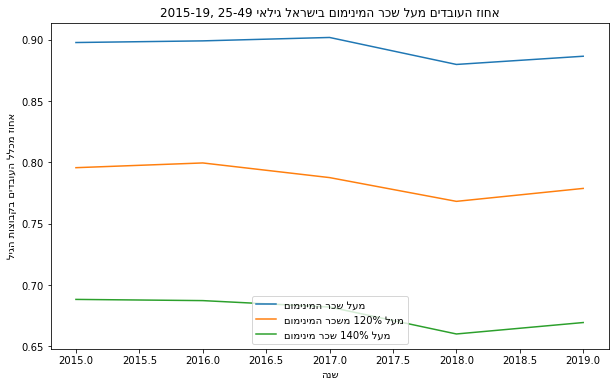

In [36]:
## Plotting the results
x=df_by_year["year"]
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x, df_by_year["מעל שכר המינימום"], label="מעל שכר המינימום"[::-1])
ax.plot(x, df_by_year["מעל 120% משכר המינימום"], label="מעל %021 משכר המינימום" [::-1])
ax.plot(x, df_by_year["מעל 140% שכר מינימום"], label="מעל %041 שכר מינימום" [::-1])
ax.set_xlabel('שנה'[::-1])
ax.set_ylabel('אחוז מכלל העובדים בקבוצות הגיל'[::-1])
ax.set_title( 'אחוז העובדים מעל שכר המינימום בישראל גילאי 94-52 ,91-5102' [::-1])

ax.legend()
source = 'מקור: עיבוד לסקרי הוצאות משקי הבית 9102-5102, הלמ"ס'    
#plt.annotate(source[::-1], xy = (2014.8, 0.61), annotation_clip = False)
plt.show()

## Saving the plot
fig.savefig("min_wage.png")


In [37]:
## Percent of individuals above min wage by gender 2018 only

df = df.loc[(df["year"]==2018)]
df_by_gender = pd.DataFrame()

def recode_gender(g):
    if g == 2:
        return "נשים"
    elif g==1:
        return "גברים"

df["gender"]= df["gender"].apply(recode_gender)

for gender in df.gender.unique():
    data = df.loc[(df["gender"]==gender)]
    above_a = DescrStatsW(data["is_above_min_wage"], weights=data["weight"])
    above = above_a.mean
    above_std = above_a.std
    above_120_a = DescrStatsW(data["is_above_120_min_wage"], weights=data["weight"])
    above_120 = above_120_a.mean
    above_120_std = above_120_a.std
    above_140_a = DescrStatsW(data["is_above_140_min_wage"], weights=data["weight"])
    above_140 = above_140_a.mean
    above_140_std = above_140_a.std
    print(f"{gender} - {above:.2%}, {above_std:.2} -> {above_120:.2%}, {above_120_std:.2}  -> {above_140:.2%}, {above_140_std:.2}")
    df_by_gender = df_by_gender.append({"Gender": gender, "מעל שכר המינימום": above, "מעל 120% משכר המינימום": above_120, "מעל 140% שכר מינימום": above_140}, ignore_index=True)



נשים - 86.16%, 0.35 -> 72.85%, 0.44  -> 61.90%, 0.49
גברים - 89.71%, 0.3 -> 80.58%, 0.4  -> 69.89%, 0.46


In [38]:
## Percent of individuals above min wage by schooling 2018 only

df = df.loc[(df["year"]==2018)]
df_by_school = pd.DataFrame()

## Recode school variable
def recode_school(x):
    if x <= 9:
        return "עד 12 שנות לימוד"
    elif x == 10:    
        return "השכלה על תיכונית חרדית"
    elif x == 11:    
        return "השכלה על תיכונית מקצועית"
    elif x == 12 or x== 13:
        return "השכלה אקדמית"
    elif x==14:
        return "השכלה אחרת"
    else:
        return "לא ידוע"
df["hascala"] = df["l_school"].apply(recode_school)

for school in df.hascala.unique():
    data = df.loc[(df["hascala"]==school)]
    above_a = DescrStatsW(data["is_above_min_wage"], weights=data["weight"])
    above = above_a.mean
    above_std = above_a.std
    above_120_a = DescrStatsW(data["is_above_120_min_wage"], weights=data["weight"])
    above_120 = above_120_a.mean
    above_120_std = above_120_a.std
    above_140_a = DescrStatsW(data["is_above_140_min_wage"], weights=data["weight"])
    above_140 = above_140_a.mean
    above_140_std = above_140_a.std
    print(f"{school} - {above:.2%}, {above_std:.2} -> {above_120:.2%}, {above_120_std:.2}  -> {above_140:.2%}, {above_140_std:.2}")
    df_by_school = df_by_school.append({"School": school, "מעל שכר המינימום": above, "מעל 120% משכר המינימום": above_120, "מעל 140% שכר מינימום": above_140}, ignore_index=True)

השכלה אקדמית - 94.88%, 0.22 -> 88.89%, 0.31  -> 81.71%, 0.39
השכלה על תיכונית מקצועית - 86.86%, 0.34 -> 74.49%, 0.44  -> 62.25%, 0.48
עד 12 שנות לימוד - 78.63%, 0.41 -> 60.82%, 0.49  -> 45.39%, 0.5
השכלה על תיכונית חרדית - 84.76%, 0.36 -> 69.35%, 0.46  -> 59.03%, 0.49
השכלה אחרת - 93.02%, 0.25 -> 89.74%, 0.3  -> 79.38%, 0.4
לא ידוע - 71.20%, 0.45 -> 33.73%, 0.47  -> 15.08%, 0.36


In [39]:
## Export to file
writer = pd.ExcelWriter('min_wage.xlsx', engine='xlsxwriter')
df_by_year.to_excel(writer,sheet_name="by_year", index=False)
df_by_gender.to_excel(writer,sheet_name= "by_gender", index=False)
df_by_school.to_excel(writer,sheet_name= "by_school", index=False)

writer.save()
